## In this notebook, we make an attempt to improve our blending(Or ensembling) by using ranks instead of absolute numbers.
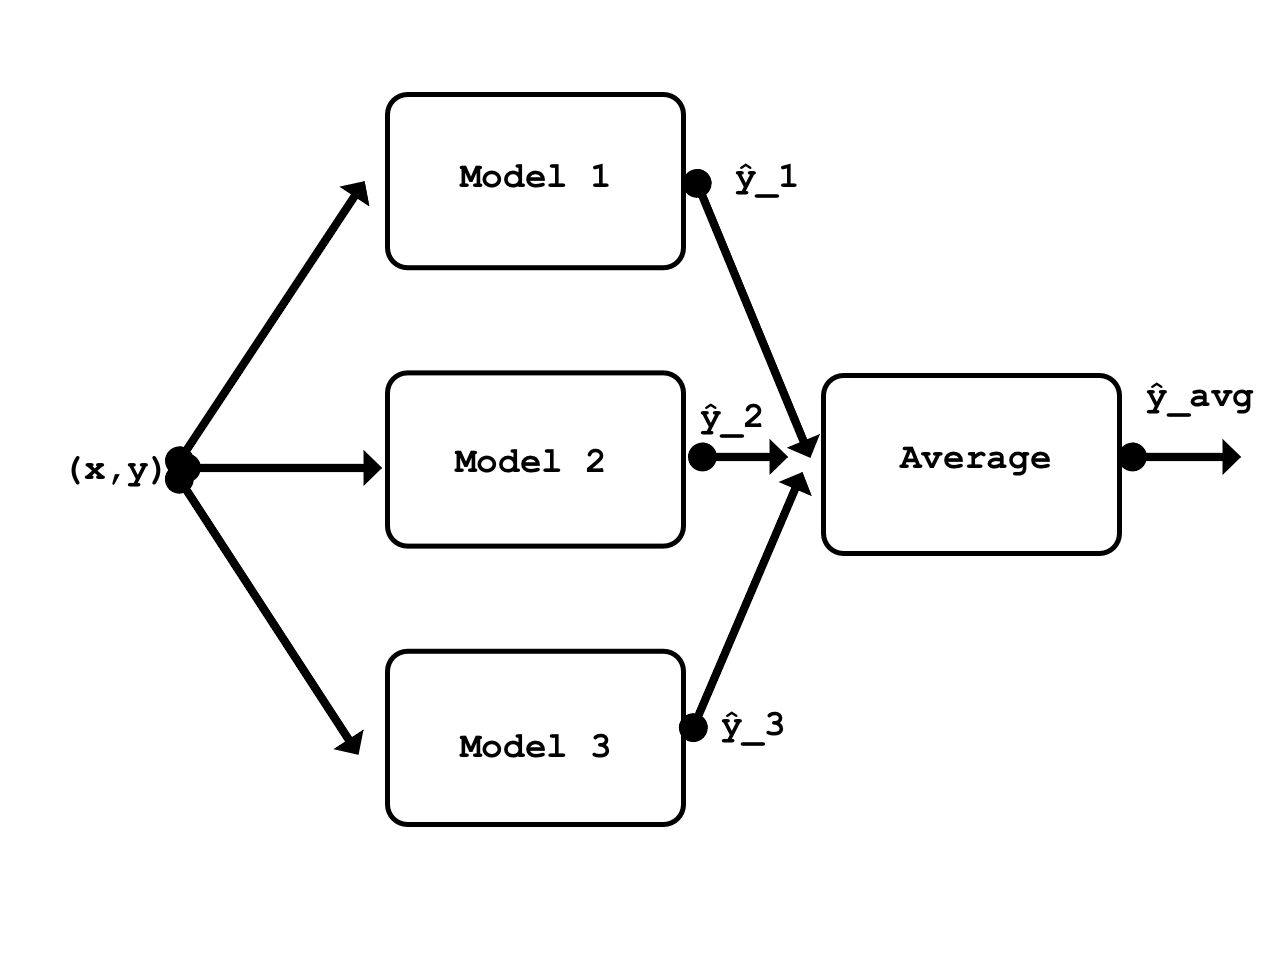
#### Reasoning behind this logic is that the ROC-AUC metric used here only cares about the rank of the prediction(Explained Below)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.listdir('../input/efficientnets/')
PATH = 'input/efficientnets'

In [3]:
dfs = []
i = 0
for df_loc in os.listdir('../input/efficientnets/'):
    print('../input/efficientnets/{}'.format(df_loc))
    df = pd.read_csv('../input/efficientnets/{}'.format(df_loc))
#     df.head()
    dfs.append(df)
# dfs    

../input/efficientnets/submission_b7_0.888.csv
../input/efficientnets/submission_b5.csv
../input/efficientnets/submission_b7.csv
../input/efficientnets/submission_b5 (1).csv


> **Dmytro Danevskyi wrote:**
> 
> The target metric in this competition is based on ranks rather than on actual values. That means that as long as the order of your values is fixed, the metric will stay the same.
> 
> To illustrate:
> 
> ```
> target = [1, 0, 1, 1, 0]
> preds = [0.5, 0.25, 0.2, 0.3, 0.1]
> 
> metric = roc_auc_score(target, preds)  # 0.833
> 
> target = [1, 0, 1, 1, 0]
> preds = [0.7, 0.15, 0.1, 0.2, 0.05]
> 
> metric = roc_auc_score(target, preds)  # 0.833
> ```
> 
> As you can see, only the rank of the predictions matters. Not the actual value.

> That means that two different models that give the **same** score could actually output completely **different** values. They are not even required to be in (0, 1) range!
> 
> ```
> target = [1, 0, 1, 1, 0]
> preds = [100, 25, 20, 30, 10]
> 
> metric = roc_auc_score(target, preds)  # 0.833
> ```
> 
> Then, if you will try to average the predictions of two non-calibrated models, you might observe that the score is not necessarily getting better and in some cases, it could become even worse! This happens because the prediction scales of these two models are not directly comparable because of the aforementioned issue.
> 
> How this can be fixed?
> 
> One simple solution is to bring the predictions to the same scale, e.g. with `scipy.stats.rankdata` function. This will turn scores into ranks, i.e. `[0.7, 0.15, 0.1, 0.2, 0.05]` will be turned into `[5, 3, 2, 4, 1]`. After this, the predictions could be blended.
> 
> Note that this not always lead to better results and is highly dependent on which exactly models are blended, how strong is the bias, and so on.
> 
> To illustrate, I decided to naively blend my best scoring model (ResNet18) that gives 0.914 on the public leaderboard with the best-scoring public kernel available (0.927) and I got 0.925. After I preprocessed both predictions with `rankdata`, my score improved to 0.933.



## Taking advantage of this information, let's try blending using rank
* (Not absolute values)
* Previous score was 0.888

In [4]:
from scipy.stats import rankdata

In [5]:
for i in range(4) :
    dfs[i]['target'] = rankdata(dfs[i]['target'], method='min')
# dfs[0]

In [6]:
dfs[0]['target'] = (dfs[0]['target'] + dfs[1]['target'] + dfs[2]['target'] + dfs[3]['target'])/4

In [7]:
dfs[0]

,image_name,target
0,ISIC_0052060,4152.25
1,ISIC_0052349,2169.75
2,ISIC_0058510,5413.00
3,ISIC_0073313,3864.00
4,ISIC_0073502,7222.75
...,...,...
10977,ISIC_9992485,3422.75
10978,ISIC_9996992,8400.00
10979,ISIC_9997917,9282.25
10980,ISIC_9998234,3649.50


* Ranking again

In [8]:

dfs[0]['target'] = rankdata(dfs[0]['target'], method='min')
dfs[0].to_csv('sol.csv' , index = False)